In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import trimesh

# ---- paths: update these ----
rgb_path  = "chair_webots/image.jpg"     # your 324x324 RGB
mask_path = "chair_webots/0.png"      # binary chair mask (white chair on black)
ply_path  = "gaussians/single/chair.ply"     # reconstructed point cloud (.ply)

# intrinsics/extrinsics text files exported from Webots
intr_path = "chair_webots/intrinsics.txt"
extr_path = "chair_webots/extrinsic_camera.txt"

RGB: (324, 324, 3) Mask: (324, 324) mask coverage: 0.0653101661332114


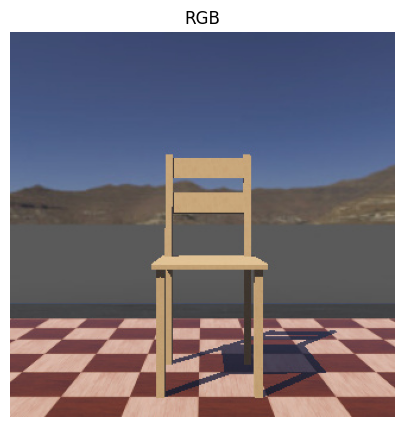

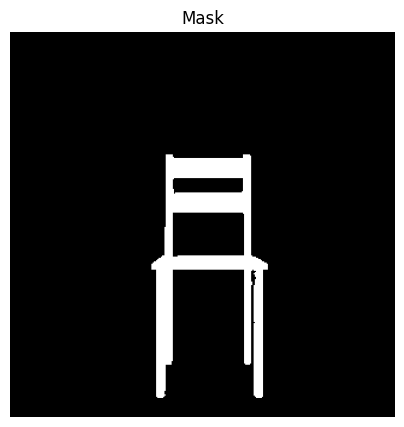

In [2]:
rgb = np.array(Image.open(rgb_path).convert("RGB"))
H, W = rgb.shape[:2]

mask_img = np.array(Image.open(mask_path).convert("L"))
mask = (mask_img > 127)  # bool mask, shape (H,W)

print("RGB:", rgb.shape, "Mask:", mask.shape, "mask coverage:", mask.mean())

plt.figure(figsize=(5,5))
plt.imshow(rgb)
plt.title("RGB")
plt.axis("off")
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")
plt.show()


In [3]:
pc = trimesh.load(ply_path, process=False)

if hasattr(pc, "vertices"):
    points = np.asarray(pc.vertices, dtype=np.float32)
else:
    points = np.asarray(pc.points, dtype=np.float32)

print("PCD shape:", points.shape)
print("PCD min:", points.min(0))
print("PCD max:", points.max(0))
print("PCD mean:", points.mean(0))


PCD shape: (284544, 3)
PCD min: [-0.2984029  -0.3328535  -0.49904558]
PCD max: [0.3004129  0.32970417 0.49858648]
PCD mean: [ 0.000865    0.02287973 -0.01618291]


In [4]:
def load_K(path):
    rows = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip().replace("[","").replace("]","")
            if not line or line.startswith("K") or line.startswith("0 0 1"):
                continue
            parts = line.split()
            if len(parts) == 3:
                rows.append([float(parts[0]), float(parts[1]), float(parts[2])])
    if len(rows) == 2:
        rows.append([0.0, 0.0, 1.0])
    return np.array(rows, dtype=np.float32)

K = load_K(intr_path)
print("K:\n", K)
print("cx,cy vs center:", (float(K[0,2]), float(K[1,2])), "vs", (W/2, H/2))


K:
 [[348.622   0.    162.   ]
 [  0.    348.622 162.   ]
 [  0.      0.      1.   ]]
cx,cy vs center: (162.0, 162.0) vs (162.0, 162.0)


In [11]:
def load_Traw_3x4(path):
    rows = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line or "Extrinsic" in line:
                continue
            parts = line.split()
            if len(parts) == 4:
                rows.append([float(x) for x in parts])
    M = np.array(rows, dtype=np.float32)  # (3,4)
    T = np.eye(4, dtype=np.float32)
    T[:3,:4] = M
    return T

T_raw = load_Traw_3x4(extr_path)
print("T_raw:\n", T_raw)

# In YOUR case, the "better" behavior came from using inverse:
T_use = T_raw  # use as-is
print("\nT_use = inv(T_raw):\n", T_use)


T_raw:
 [[ 1.0000000e+00  9.7912001e-05 -0.0000000e+00  3.1232080e-01]
 [-9.7912001e-05  1.0000000e+00  0.0000000e+00  5.2534980e-01]
 [ 0.0000000e+00 -0.0000000e+00  1.0000000e+00 -6.4200413e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

T_use = inv(T_raw):
 [[ 1.0000000e+00  9.7912001e-05 -0.0000000e+00  3.1232080e-01]
 [-9.7912001e-05  1.0000000e+00  0.0000000e+00  5.2534980e-01]
 [ 0.0000000e+00 -0.0000000e+00  1.0000000e+00 -6.4200413e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [12]:
chair_center_world = np.array([1.43, -0.54, 0.0], dtype=np.float32)
print("chair_center_world:", chair_center_world)


chair_center_world: [ 1.43 -0.54  0.  ]


In [13]:
# Empirical camera basis (from your forward-axis test)
FORWARD = np.array([1,0,0], np.float32)   # +X is depth
RIGHT   = np.array([0,1,0], np.float32)   # +Y is image +u
UP      = np.array([0,0,-1], np.float32)  # -Z is image +v  (note minus!)

def project_with_basis(points_world, K, w2c, forward, right, up):
    Pw = np.asarray(points_world, dtype=np.float32).reshape(-1,3)
    N = Pw.shape[0]
    Ph = np.hstack([Pw, np.ones((N,1), np.float32)])
    Pc = (w2c @ Ph.T).T[:, :3]

    depth = Pc @ forward
    x = Pc @ right
    y = Pc @ up

    eps = 1e-8
    depth2 = np.where(np.abs(depth) < eps, eps, depth)

    u = K[0,0] * (x / depth2) + K[0,2]
    v = K[1,1] * (y / depth2) + K[1,2]
    return u, v, depth


In [ ]:
BEST_YAW = -90.0  

def Rz(deg):
    a = np.deg2rad(deg)
    c, s = np.cos(a), np.sin(a)
    return np.array([[c,-s,0],
                     [s, c,0],
                     [0, 0,1]], dtype=np.float32)

#center PCD at 0 
P = points.astype(np.float32)
P = P - P.mean(axis=0, keepdims=True)

#yaw align
R = Rz(BEST_YAW)
P = P @ R.T

#lift so it’s not below

# strict min
zmin = float(P[:,2].min())
z_shift = -zmin

# robust 1% quantile
# z_low = float(np.quantile(P[:,2], 0.01))
# z_shift = -z_low

P[:,2] += z_shift
print("Applied yaw:", BEST_YAW, "deg, z_shift:", z_shift)

#place into world at chair location
Pw = P + chair_center_world.reshape(1,3)
print("Pw mean:", Pw.mean(0), "Pw z range:", Pw[:,2].min(), Pw[:,2].max())


Applied yaw: -90.0 deg, z_shift: 0.4828626811504364
Pw mean: [ 1.4303493 -0.5399501  0.4827821] Pw z range: 0.0 0.997632


in_front: 284544 / 284544
in_img: 284544 / 284544
u range(front): 85.36033630371094 232.86412048339844
v range(front): 98.2044677734375 321.81243896484375


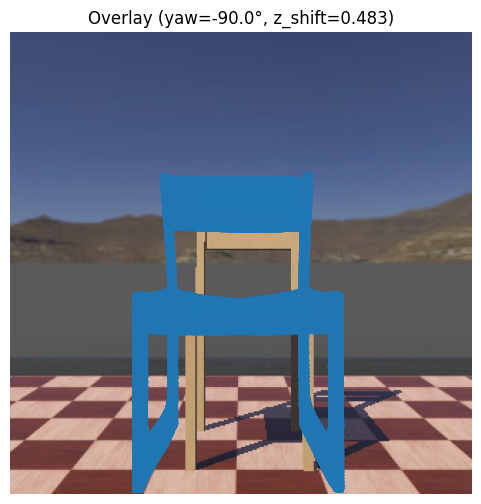

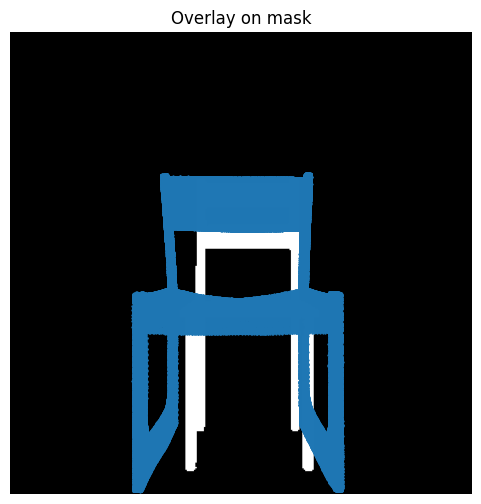

In [20]:
u, v, depth = project_with_basis(Pw, K, T_use, FORWARD, RIGHT, UP)

in_front = depth > 1e-3
in_img = in_front & (u>=0) & (u<W) & (v>=0) & (v<H)

print("in_front:", int(in_front.sum()), "/", len(depth))
print("in_img:", int(in_img.sum()), "/", len(depth))
print("u range(front):", float(u[in_front].min()), float(u[in_front].max()))
print("v range(front):", float(v[in_front].min()), float(v[in_front].max()))

plt.figure(figsize=(6,6))
plt.imshow(rgb)
plt.scatter(u[in_img], v[in_img], s=0.5)
plt.title(f"Overlay (yaw={BEST_YAW}°, z_shift={z_shift:.3f})")
plt.axis("off")
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(mask, cmap="gray")
plt.scatter(u[in_img], v[in_img], s=0.5)
plt.title("Overlay on mask")
plt.axis("off")
plt.show()


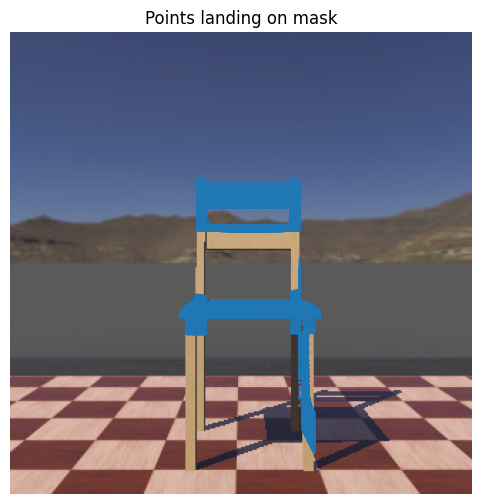

In [21]:
uu = np.clip(np.rint(u[in_img]).astype(int), 0, W-1)
vv = np.clip(np.rint(v[in_img]).astype(int), 0, H-1)
on = mask[vv, uu] > 0

plt.figure(figsize=(6,6))
plt.imshow(rgb)
plt.scatter(u[in_img][on], v[in_img][on], s=0.5)
plt.title("Points landing on mask")
plt.axis("off")
plt.show()
